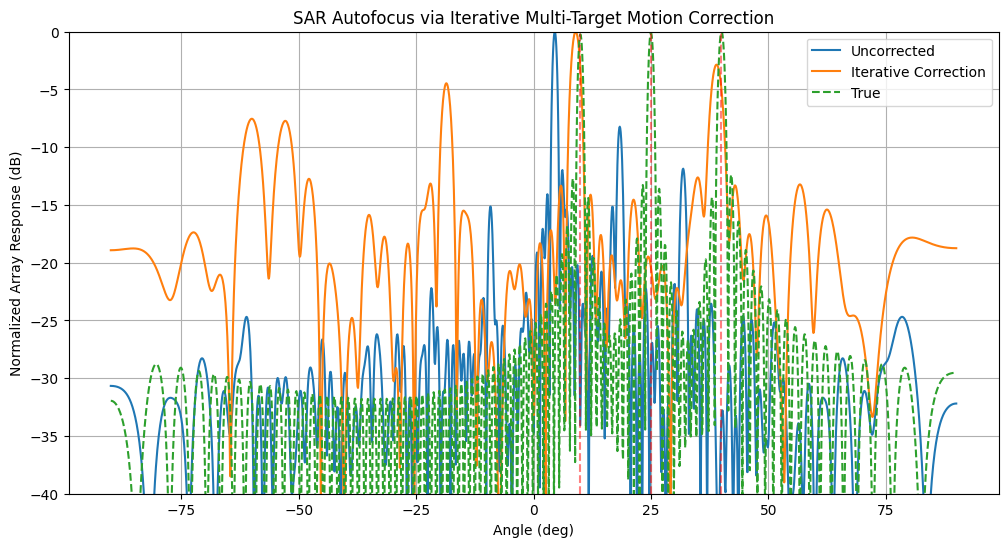

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Simulation Parameters
# -------------------------------
c = 3e8
f0 = 77e9            # carrier frequency
B = 200e6            # FMCW bandwidth
T_chirp = 1e-3       # chirp duration
Ns = 256             # samples per chirp
N_chirps = 100       # number of chirps / synthetic array positions
dt = 0.01            # time between snapshots
v_true = 0.2         # true UAV velocity (m/s)
v_bias = 0.01        # assumed velocity bias in synthetic array
num_targets = 3
target_ranges = np.array([15, 20, 25])  # meters
target_rcs = np.array([1, 0.8, 0.5])
theta_targets = np.array([10, 25, 40])  # degrees
lam = c/f0

sigma_phase_err = 0.3 # random phase noise per snapshot

# -------------------------------
# Derived parameters
# -------------------------------
x_true = np.arange(N_chirps) * v_true * dt
x_assumed = np.arange(N_chirps) * (v_true+v_bias) * dt
t = np.linspace(0, T_chirp, Ns)

# -------------------------------
# Generate FMCW waveform per target
# -------------------------------
def fmcw_chirp(t, B, T):
    return np.exp(1j*np.pi*B/T * t**2)  # baseband linear chirp

# Precompute transmitted chirp
tx_chirp = fmcw_chirp(t, B, T_chirp)

# Generate received signal per chirp and per target
rx = np.zeros((N_chirps, Ns), dtype=complex)
for k in range(num_targets):
    r = target_ranges[k]
    theta = np.deg2rad(theta_targets[k])
    delay = 2*r/c
    phase_shift = 2*np.pi/lam * x_true * np.sin(theta)
    for n in range(N_chirps):
        # simple delayed chirp + phase ramp for synthetic aperture
        delayed_samples = np.roll(tx_chirp, int(delay/T_chirp*Ns))  # approximate delay
        rx[n,:] += target_rcs[k] * delayed_samples * np.exp(1j*(phase_shift[n]+np.random.randn()*sigma_phase_err))

# -------------------------------
# Range FFT per chirp
# -------------------------------
range_fft = np.fft.fft(rx, axis=1)
range_axis = np.fft.fftfreq(Ns, T_chirp/Ns) * c / (2*B) * T_chirp  # approximate range bins

# Select N strongest range bins
N_peaks = 3
range_mags = np.abs(range_fft)
peak_bins = np.argsort(range_mags.max(axis=0))[-N_peaks:]

# -------------------------------
# Extract per-target phase across chirps
# -------------------------------
s_meas = np.zeros((N_chirps, N_peaks), dtype=complex)
for idx, b in enumerate(peak_bins):
    s_meas[:,idx] = range_fft[:,b]

# -------------------------------
# Iterative motion correction
# -------------------------------
max_iter = 5
x_corr = np.copy(x_assumed)

for it in range(max_iter):
    # Estimate per-chirp phase error for each target
    delta_x = np.zeros(N_chirps)
    for k in range(N_peaks):
        # Estimate angle from phase slope across synthetic array
        s = s_meas[:,k]
        # Phase difference between snapshots
        phi_diff = np.angle(s[1:] * np.conj(s[:-1]))
        # Convert phase differences to delta_x estimates (assume small angle per snapshot)
        theta = np.deg2rad(theta_targets[k])  # for simplicity, assume known
        dx = (lam/(2*np.pi*np.sin(theta))) * np.insert(np.cumsum(phi_diff),0,0)
        delta_x += dx
    # Average across targets
    delta_x /= N_peaks
    # Correct platform positions
    x_corr -= delta_x
    # Update synthetic array phase for next iteration
    for k in range(N_peaks):
        theta = np.deg2rad(theta_targets[k])
        s_meas[:,k] *= np.exp(-1j*2*np.pi/lam * delta_x * np.sin(theta))

# -------------------------------
# Compute array response after correction
# -------------------------------
angles = np.linspace(-90, 90, 1800)
angles_rad = np.deg2rad(angles)

def array_response(synthetic_phases, x, angles_rad, lam):
    resp = []
    for th in angles_rad:
        steering = np.exp(1j*2*np.pi/lam * x * np.sin(th))
        resp.append(np.abs(np.sum(synthetic_phases * np.conj(steering))))
    return np.array(resp)/len(synthetic_phases)

# Use strongest corrected target for visualization
resp_uncorr = array_response(s_meas[:,0], x_assumed, angles_rad, lam)
resp_corr = array_response(s_meas[:,0], x_corr, angles_rad, lam)

# True response
s_true_all = np.zeros(N_chirps, dtype=complex)
for k in range(num_targets):
    theta = np.deg2rad(theta_targets[k])
    s_true_all += np.exp(1j*2*np.pi/lam * x_true * np.sin(theta))
resp_true = array_response(s_true_all, x_true, angles_rad, lam)

# -------------------------------
# Plot results
# -------------------------------
plt.figure(figsize=(12,6))
plt.plot(angles, 20*np.log10(resp_uncorr/resp_uncorr.max()), label='Uncorrected')
plt.plot(angles, 20*np.log10(resp_corr/resp_corr.max()), label='Iterative Correction')
plt.plot(angles, 20*np.log10(resp_true/resp_true.max()), '--', label='True')
for t in theta_targets:
    plt.axvline(t, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Angle (deg)')
plt.ylabel('Normalized Array Response (dB)')
plt.title('SAR Autofocus via Iterative Multi-Target Motion Correction')
plt.grid(True)
plt.ylim([-40, 0])
plt.legend()
plt.show()


/home/david/.cache/pypoetry/virtualenvs/mmwave-radar-processing-ERvCMkmn-py3.12/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


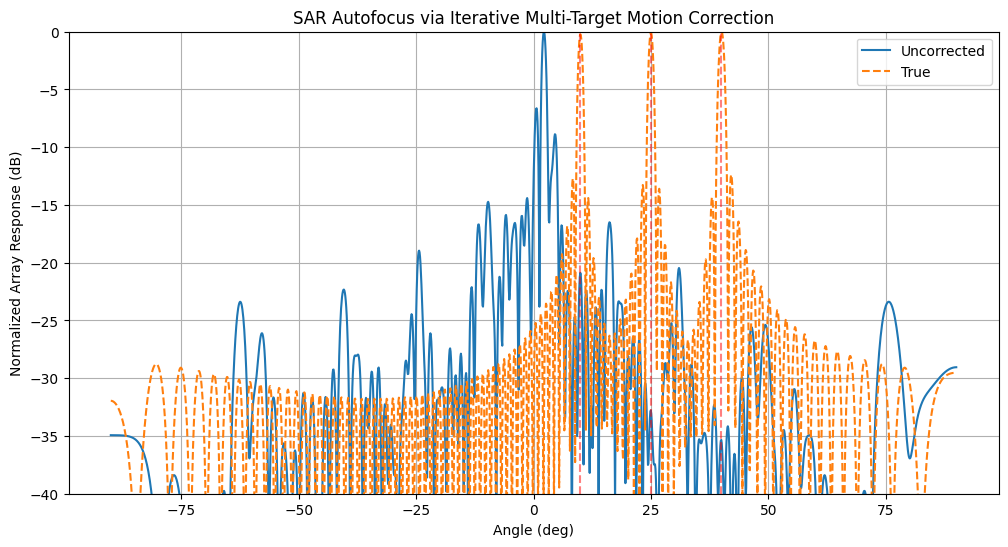

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Simulation Parameters
# -------------------------------
c = 3e8
f0 = 77e9            # carrier frequency
B = 200e6            # FMCW bandwidth
T_chirp = 1e-3       # chirp duration
Ns = 256             # samples per chirp
N_chirps = 100       # number of chirps / synthetic array positions
dt = 0.01            # time between snapshots
v_true = 0.2         # true UAV velocity (m/s)
v_bias = 0.01        # assumed velocity bias in synthetic array
num_targets = 3
target_ranges = np.array([15, 20, 25])  # meters
target_rcs = np.array([1, 0.8, 0.5])
theta_targets = np.array([10, 25, 40])  # degrees
lam = c/f0

sigma_phase_err = 0.05 # random phase noise per snapshot

# -------------------------------
# Derived parameters
# -------------------------------
x_true = np.arange(N_chirps) * v_true * dt
x_assumed = np.arange(N_chirps) * (v_true+v_bias) * dt
t = np.linspace(0, T_chirp, Ns)

# -------------------------------
# Generate FMCW waveform per target
# -------------------------------
def fmcw_chirp(t, B, T):
    return np.exp(1j*np.pi*B/T * t**2)  # baseband linear chirp

# Precompute transmitted chirp
tx_chirp = fmcw_chirp(t, B, T_chirp)

# Generate received signal per chirp and per target
rx = np.zeros((N_chirps, Ns), dtype=complex)
for k in range(num_targets):
    r = target_ranges[k]
    theta = np.deg2rad(theta_targets[k])
    delay = 2*r/c
    phase_shift = 2*np.pi/lam * x_true * np.sin(theta)
    for n in range(N_chirps):
        # simple delayed chirp + phase ramp for synthetic aperture
        delayed_samples = np.roll(tx_chirp, int(delay/T_chirp*Ns))  # approximate delay
        rx[n,:] += target_rcs[k] * delayed_samples * np.exp(1j*(phase_shift[n]+np.random.randn()*sigma_phase_err))

# -------------------------------
# Range FFT per chirp
# -------------------------------
range_fft = np.fft.fft(rx, axis=1)
range_axis = np.fft.fftfreq(Ns, T_chirp/Ns) * c / (2*B) * T_chirp  # approximate range bins

# Select N strongest range bins
N_peaks = 3
range_mags = np.abs(range_fft)
peak_bins = np.argsort(range_mags.max(axis=0))[-N_peaks:]

# -------------------------------
# Extract per-target phase across chirps
# -------------------------------
s_meas = np.zeros((N_chirps, N_peaks), dtype=complex)
for idx, b in enumerate(peak_bins):
    s_meas[:,idx] = range_fft[:,b]

# -------------------------------
# Iterative motion correction
# -------------------------------
max_iter = 5
x_corr = np.copy(x_assumed)

for it in range(max_iter):
    delta_x_all = []
    for k in range(N_peaks):
        s = s_meas[:,k]
        phi = np.unwrap(np.angle(s))
        phi_diff = np.diff(phi)
        theta = np.deg2rad(theta_targets[k])
        dx = (lam/(2*np.pi*np.sin(theta))) * np.insert(np.cumsum(phi_diff),0,0)
        delta_x_all.append(dx)
    
    # Stack and average
    delta_x_all = np.vstack(delta_x_all)
    delta_x = np.mean(delta_x_all, axis=0)
    
    # Correct platform trajectory only (do NOT also modify s_meas)
    x_corr -= delta_x

    # Recompute s_meas using corrected x_corr
    for idx, b in enumerate(peak_bins):
        theta = np.deg2rad(theta_targets[idx])
        s_meas[:,idx] = np.exp(1j*2*np.pi/lam * x_corr * np.sin(theta))


# -------------------------------
# Compute array response after correction
# -------------------------------
angles = np.linspace(-90, 90, 1800)
angles_rad = np.deg2rad(angles)

def array_response(synthetic_phases, x, angles_rad, lam):
    resp = []
    for th in angles_rad:
        steering = np.exp(1j*2*np.pi/lam * x * np.sin(th))
        resp.append(np.abs(np.sum(synthetic_phases * np.conj(steering))))
    return np.array(resp)/len(synthetic_phases)

# Use strongest corrected target for visualization
resp_uncorr = array_response(s_meas[:,0], x_assumed, angles_rad, lam)
resp_corr = array_response(s_meas[:,0], x_corr, angles_rad, lam)

# True response
s_true_all = np.zeros(N_chirps, dtype=complex)
for k in range(num_targets):
    theta = np.deg2rad(theta_targets[k])
    s_true_all += np.exp(1j*2*np.pi/lam * x_true * np.sin(theta))
resp_true = array_response(s_true_all, x_true, angles_rad, lam)

# -------------------------------
# Plot results
# -------------------------------
plt.figure(figsize=(12,6))
plt.plot(angles, 20*np.log10(resp_uncorr/resp_uncorr.max()), label='Uncorrected')
# plt.plot(angles, 20*np.log10(resp_corr/resp_corr.max()), label='Iterative Correction')
plt.plot(angles, 20*np.log10(resp_true/resp_true.max()), '--', label='True')
for t in theta_targets:
    plt.axvline(t, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Angle (deg)')
plt.ylabel('Normalized Array Response (dB)')
plt.title('SAR Autofocus via Iterative Multi-Target Motion Correction')
plt.grid(True)
plt.ylim([-40, 0])
plt.legend()
plt.show()
